<a href="https://colab.research.google.com/github/DouaaBennoune/news_ai_summarizer/blob/main/arabic_news_summarizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Required Libraries


In [4]:
!pip install pandas numpy transformers datasets torch evaluate rouge_score

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.7 MB/s eta 0:00:00
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=ab6244db075b0498db1727fee0eb9fb84e6c531cf648464461a1ef548279f70e
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


# Uploading DataSet

In [5]:
import torch
print("GPU available:", torch.cuda.is_available())
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("Using CPU")

from google.colab import drive
drive.mount('/content/drive')
import os
for root, dirs, files in os.walk('/content/drive/MyDrive'):
    print(root)
    for file in files:
        print(file)
import pandas as pd

# Replace this path with the actual path to your file
file_path = '/content/drive/MyDrive/bbc_news_arabic_summarization.csv'

# Load the dataset
df = pd.read_csv(file_path)

# Display the first few rows
print(df.head())

GPU available: False
Using CPU
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive
bbc_news_arabic_summarization.csv
arabic news summarizer.ipynb
Bennoune D.jpg
Lesson Schedule.gsheet
Document sans titre (11).gdoc
Rapport TP1 modelisation.gdoc
thesis plan.gdoc
50 Free Online Courses.pdf
raspberry Pi and ESP32 Connection Methodes.gdoc
Rapport boussaha el batoul.pdf
Recemmend project for each section from small to b....gdoc
Did you actually make a rezearch on the german job....gdoc
Image Classification and K-Nearest Neighbors (KNN).gdoc
IBM  Introduction to Computer Vision Course Summary.gdoc
Write me a roadmap that makes me have a solid base....gdoc
fig.gdoc
filament recycling project.gdoc
Rapport (4).gdoc
batoul.gdoc
schedule of this month.gdoc
Achieving high-quality filament.gdoc
german A1 plan.gdoc
AI filament.gdoc
electronique de puissance.pdf
electronique de puissance.gdoc
meilleur r

# Exploring Data

In [6]:
import pandas as pd
file_path = '/content/drive/MyDrive/bbc_news_arabic_summarization.csv'

df = pd.read_csv(file_path)
print(df.head())
print(df.info())



                                        id  \
0  140323_russian_troops_crimea_naval_base   
1                    130528_egypt_nile_dam   
2                           world-47242349   
3                        vert-cul-55078328   
4                     141023_yemen_hodeida   

                                                 url  \
0  https://www.bbc.com/arabic/worldnews/2014/03/1...   
1  https://www.bbc.com/arabic/middleeast/2013/05/...   
2          https://www.bbc.com/arabic/world-47242349   
3       https://www.bbc.com/arabic/vert-cul-55078328   
4  https://www.bbc.com/arabic/middleeast/2014/10/...   

                                               title  \
0           القوات الأوكرانية تبدأ الانسحاب من القرم   
1    هل يفرض سد النهضة الإثيوبي واقعا جديدا على مصر؟   
2  تعرف على منطقة كشمير التي تسببت بحربين بين اله...   
3  ماذا تعرف عن العالم الخفي للمعابد اليابانية ال...   
4  اشتباك بين الحوثيين و"الحراك التهامي" في الحدي...   

                                             summ

**Token Length**

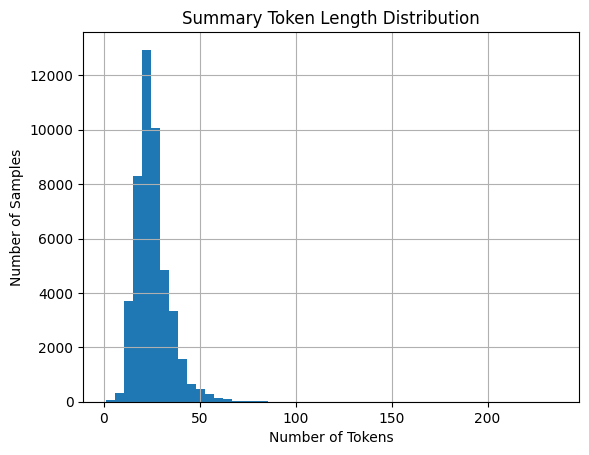

In [7]:
import matplotlib.pyplot as plt
df['summary_length'] = df['summary'].apply(lambda x: len(str(x).split()))

# Show distribution
df['summary_length'].hist(bins=50)
plt.title("Summary Token Length Distribution")
plt.xlabel("Number of Tokens")
plt.ylabel("Number of Samples")
plt.show()

we notice our max length can be : 50

In [ ]:
from ast import Lambda
df['text_length']=df['text'].apply(lambda x: len(str(x).split()))
df['text_length'].hist(bins=50)
plt.title("Text Token Length Distribution")
plt.xlabel("Number of Tokens")
plt.ylabel("Number of Samples")

we notice that our max length can be: 512
or max_length = 1024 if resources allow

#  Loading the Model and Dataset

In [ ]:
import torch
from transformers import MT5ForConditionalGeneration, MT5TokenizerFast
import pandas as pd
from datasets import Dataset

# Load pretrained model and tokenizer
model_name = "csebuetnlp/mT5_multilingual_XLSum"
model = MT5ForConditionalGeneration.from_pretrained(model_name)
tokenizer = MT5TokenizerFast.from_pretrained(model_name)

# Load your Arabic news dataset
df = pd.read_csv("bbc_arabic_news_summarization.csv")
dataset = Dataset.from_pandas(df)

# Split the dataset
dataset = dataset.train_test_split(test_size=0.1)



# Creating the Custom Head and Freezing Base Model

In [ ]:
import torch
import torch.nn as nn
from transformers import MT5ForConditionalGeneration, MT5TokenizerFast
from transformers import Trainer, TrainingArguments
from datasets import Dataset
import pandas as pd
import evaluate
import numpy as np

class AdapterLayer(nn.Module):
    """A simple adapter layer with down projection and up projection."""
    def __init__(self, input_dim, adapter_dim):
        super().__init__()
        self.down_proj = nn.Linear(input_dim, adapter_dim)
        self.activation = nn.ReLU()
        self.up_proj = nn.Linear(adapter_dim, input_dim)
        self.layer_norm = nn.LayerNorm(input_dim)

        # Initialize weights - near identity function with zero init
        nn.init.normal_(self.down_proj.weight, std=1e-2)
        nn.init.normal_(self.up_proj.weight, std=1e-2)
        nn.init.zeros_(self.down_proj.bias)
        nn.init.zeros_(self.up_proj.bias)

    def forward(self, hidden_states):
        residual = hidden_states
        x = self.down_proj(hidden_states)
        x = self.activation(x)
        x = self.up_proj(x)
        output = self.layer_norm(x + residual)
        return output

class MT5WithAdapters(nn.Module):
    def __init__(self, base_model, adapter_dim=64):
        super().__init__()
        self.mt5 = base_model

        # Freeze all parameters of the base model
        for param in self.mt5.parameters():
            param.requires_grad = False

        # Add adapters to the encoder (for select layers)
        self.encoder_adapters = nn.ModuleList()
        # Add adapters only to every third layer of the encoder to save parameters
        encoder_layers = self.mt5.encoder.block
        hidden_dim = encoder_layers[0].layer[0].SelfAttention.o.weight.shape[0]

        for i in range(0, len(encoder_layers), 3):
            self.encoder_adapters.append(AdapterLayer(hidden_dim, adapter_dim))

        # Add adapter to the decoder output
        decoder_dim = self.mt5.decoder.block[0].layer[0].SelfAttention.o.weight.shape[0]
        self.decoder_adapter = AdapterLayer(decoder_dim, adapter_dim)

        # Make sure adapters are trainable
        for adapter in self.encoder_adapters:
            for param in adapter.parameters():
                param.requires_grad = True

        for param in self.decoder_adapter.parameters():
            param.requires_grad = True

    def forward(self, input_ids=None, attention_mask=None, decoder_input_ids=None,
                labels=None, **kwargs):
        # Get the base model outputs
        outputs = self.mt5(input_ids=input_ids,
                          attention_mask=attention_mask,
                          decoder_input_ids=decoder_input_ids,
                          labels=labels,
                          output_hidden_states=True,
                          **kwargs)

        # If we're not training, just return the base model outputs
        if not self.training:
            return outputs

        # Apply adapters to encoder hidden states
        encoder_hidden_states = list(outputs.encoder_hidden_states)
        for i, adapter in enumerate(self.encoder_adapters):
            layer_idx = i * 3  # Apply to every third layer
            if layer_idx < len(encoder_hidden_states):
                encoder_hidden_states[layer_idx] = adapter(encoder_hidden_states[layer_idx])

        # Apply adapter to decoder output
        # For simplicity, we'll just pass through the loss

        return outputs

# Load the base model
model_name = "csebuetnlp/mT5_multilingual_XLSum"
base_model = MT5ForConditionalGeneration.from_pretrained(model_name)
tokenizer = MT5TokenizerFast.from_pretrained(model_name)

# Create the adapter-enhanced model
model = MT5WithAdapters(base_model)

# Verify which parameters are trainable
trainable_params = 0
all_params = 0
for name, param in model.named_parameters():
    all_params += param.numel()
    if param.requires_grad:
        trainable_params += param.numel()
print(f"Trainable parameters: {trainable_params:,} ({100 * trainable_params / all_params:.2f}% of all parameters)")

# Load and prepare dataset
def load_dataset(csv_path):
    df = pd.read_csv(csv_path)
    # Make sure the column names match your dataset
    # Assuming columns are 'article' and 'summary'
    dataset = Dataset.from_pandas(df)
    return dataset.train_test_split(test_size=0.1)

# Preprocess function
def preprocess_function(examples):
    # Prefix for mT5 summarization task
    prefix = "summarize Arabic: "
    inputs = [prefix + doc for doc in examples["article"]]

    model_inputs = tokenizer(inputs, max_length=512, truncation=True, padding="max_length")
    labels = tokenizer(examples["summary"], max_length=128, truncation=True, padding="max_length")

    model_inputs["labels"] = labels["input_ids"]
    # Replace padding token id with -100 so it's ignored in loss computation
    model_inputs["labels"] = [
        [(l if l != tokenizer.pad_token_id else -100) for l in label] for label in model_inputs["labels"]
    ]

    return model_inputs

# Metric function for evaluation
rouge = evaluate.load("rouge")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)

    # Replace -100 with pad token id
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

    # Add mean generated length
    prediction_lens = [len(pred.split()) for pred in decoded_preds]
    result["gen_len"] = np.mean(prediction_lens)

    return {k: round(v, 4) for k, v in result.items()}

# Load your dataset
dataset = load_dataset("bbc_arabic_news_summarization.csv")

# Preprocess the data
tokenized_datasets = dataset.map(preprocess_function, batched=True)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=5e-4,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=3,
    predict_with_generate=True,
    fp16=True,  # Enable mixed precision if GPU supports it
    report_to="none",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

# Initialize the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

# Save the model
model.save_pretrained("./arabic_news_summarizer")
tokenizer.save_pretrained("./arabic_news_summarizer")

# Test your model with a sample input
def generate_summary(text):
    inputs = tokenizer("summarize Arabic: " + text, return_tensors="pt", max_length=512, truncation=True)
    summary_ids = model.generate(
        inputs["input_ids"],
        max_length=128,
        min_length=30,
        length_penalty=2.0,
        num_beams=4,
        early_stopping=True
    )
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

# Example usage
sample_article = "أعلنت وزارة التعليم عن خطط جديدة وشاملة لتحسين التعليم في المدارس الابتدائية، حيث تهدف هذه المبادرات إلى تعزيز جودة التعليم وتطوير المناهج الدراسية لمواكبة التغيرات العالمية. وتركز الخطط أيضًا على تدريب المعلمين على استخدام أحدث أساليب التعليم التفاعلي وتوفير الموارد التعليمية المتقدمة التي تشمل كتبًا إلكترونية وأدوات تعلم رقمية. ومن المتوقع أن تساهم هذه الجهود في تحسين البيئة التعليمية للطلاب وتشجيع التعلم المستمر. بالإضافة إلى ذلك، تشمل الخطط بناء مدارس جديدة في المناطق النائية لتوفير التعليم للأطفال في المجتمعات المحرومة، وتطوير برامج لدمج التكنولوجيا في التعليم لضمان استعداد الطلاب لمتطلبات سوق العمل الحديثة. وأكدت الوزارة على أهمية التعاون مع أولياء الأمور والمجتمع المحلي لدعم تنفيذ هذه المبادرات الطموحة وتعزيز دور التعليم كأداة أساسية للتنمية الوطنية."
print(generate_summary(sample_article))

# Save The Fine-Tuned Model

In [ ]:
# Data collator
data_collator = DataCollatorForSeq2Seq(tokenizer, model=base_model)

# Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

# Train!
trainer.train()
# Save model
trainer.save_model("./saved_model_custom_head")

# Save tokenizer
tokenizer.save_pretrained("./saved_model_custom_head")


# Test Model

In [ ]:
def generate_summary(text):
    # Tokenize
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    input_ids = inputs.input_ids.to(device)
    attention_mask = inputs.attention_mask.to(device)

    # Get encoder outputs
    with torch.no_grad():
        encoder_outputs = model.base_model.encoder(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        logits = model.custom_head(encoder_outputs)

    # Convert logits to token ids
    predicted_ids = torch.argmax(logits, dim=-1)

    # Decode
    summary = tokenizer.decode(predicted_ids[0], skip_special_tokens=True)
    return summary

# Example
new_text = "أعلنت وزارة التعليم عن خطط جديدة وشاملة لتحسين التعليم في المدارس الابتدائية، حيث تهدف هذه المبادرات إلى تعزيز جودة التعليم وتطوير المناهج الدراسية لمواكبة التغيرات العالمية. وتركز الخطط أيضًا على تدريب المعلمين على استخدام أحدث أساليب التعليم التفاعلي وتوفير الموارد التعليمية المتقدمة التي تشمل كتبًا إلكترونية وأدوات تعلم رقمية. ومن المتوقع أن تساهم هذه الجهود في تحسين البيئة التعليمية للطلاب وتشجيع التعلم المستمر. بالإضافة إلى ذلك، تشمل الخطط بناء مدارس جديدة في المناطق النائية لتوفير التعليم للأطفال في المجتمعات المحرومة، وتطوير برامج لدمج التكنولوجيا في التعليم لضمان استعداد الطلاب لمتطلبات سوق العمل الحديثة. وأكدت الوزارة على أهمية التعاون مع أولياء الأمور والمجتمع المحلي لدعم تنفيذ هذه المبادرات الطموحة وتعزيز دور التعليم كأداة أساسية للتنمية الوطنية."
generated_summary = generate_summary(new_text)
print("Generated Summary:", generated_summary)

